build regressors to Predict House Prices 

In [117]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Load the training and testing datasets
https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [120]:
data_train = pd.read_csv("housing_train.csv")
data_test = pd.read_csv("housing_test.csv")
data_test_y = pd.read_csv("housing_test_y.csv")
data_test['SalePrice']=data_test_y['SalePrice']
data_train['train']=1
data_test['train']=0
data = pd.concat([data_train, data_test], axis=0, sort=False)
print('data_train.shape', data_train.shape)
print('data_test.shape', data_test.shape)
print('data.shape', data.shape)

data_train.shape (1460, 82)
data_test.shape (1459, 82)
data.shape (2919, 82)


In [122]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,train
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0,1
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0,1
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0,1
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0,1
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0,1


the regression target is SalePrice

In [125]:
data.head().SalePrice

0    208500.0
1    181500.0
2    223500.0
3    140000.0
4    250000.0
Name: SalePrice, dtype: float64

## Handle missing values (NaN and None)
show the missing values for each feature

In [128]:
#show the missing values in a table
Missing = pd.concat([data_train.isnull().sum(), data_test.isnull().sum()], axis=1, keys=['Train', 'Test'],sort=False)
Missing[Missing.sum(axis=1) > 0]

,Train,Test
MSZoning,0,4
LotFrontage,259,227
Alley,1369,1352
Utilities,0,2
Exterior1st,0,1
Exterior2nd,0,1
MasVnrType,872,894
MasVnrArea,8,15
BsmtQual,37,44
BsmtCond,37,45


<Axes: xlabel='None', ylabel='None'>

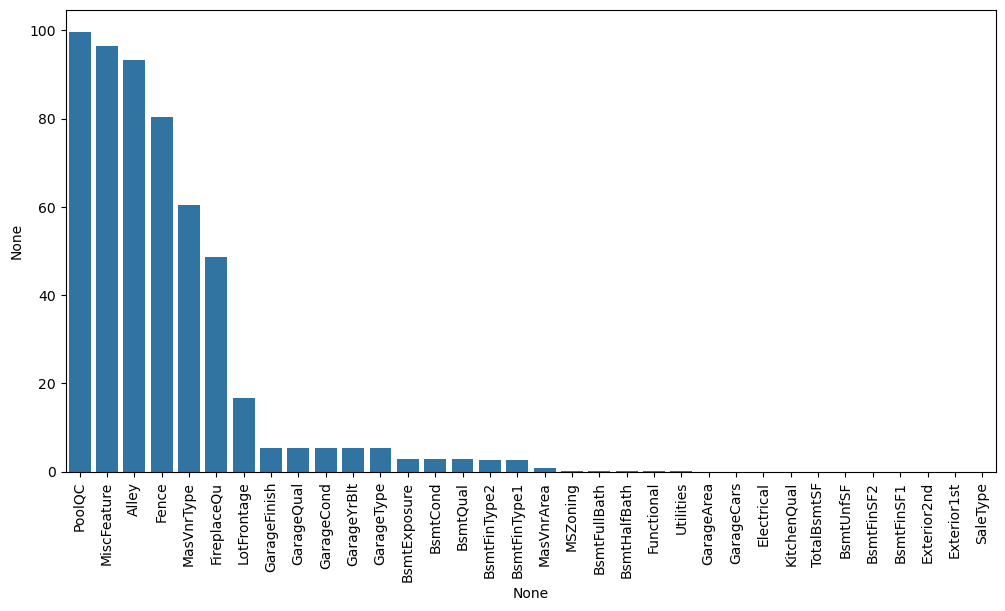

In [130]:
#show the missing values in a plot
data_missing = (data.isnull().sum(axis=0)/data.shape[0]) * 100
data_missing = data_missing.drop(data_missing[data_missing == 0].index).sort_values(ascending=False)
plt.figure(figsize=(12, 6))
plt.xticks(rotation=90)
sns.barplot(x=data_missing.index, y=data_missing)

From the figure, we see that nearly 100% values of the feature/column 'PoolQC' are missing <br>
We can simply delete these features (drop these columns from the table) of which >=50% values are missing

In [133]:
feature_drop = data_missing[data_missing >=50].index
feature_drop

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType'], dtype='object')

In [135]:
#drop the columns
data=data.drop(columns=feature_drop)
#drop Id
data=data.drop(columns='Id')

In [137]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,train
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2,2008,WD,Normal,208500.0,1
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,5,2007,WD,Normal,181500.0,1
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,9,2008,WD,Normal,223500.0,1
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,2,2006,WD,Abnorml,140000.0,1
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,12,2008,WD,Normal,250000.0,1


For those features with < 50% missing values, we can use impute method. <br>
Missing numerical values can be imputed with a constant value, or some statistics (mean, median or most frequent) of each column in which the missing values are located. <br>
Missing categorical/non-numeric values can be imputed with the most frequent category, or a new category-'nothing'

In [140]:
numerical_column=[]
categorical_column=[]
for c in data.columns:
    v=data[c]
    v=v[~v.isnull()]
    if data[c].dtype == np.dtype('O'): # non-numeric values       
        #data[c]=data[c].fillna(v.value_counts().index[0]) # the most frequent category
        data[c]=data[c].fillna('nothing') # a new category         
        categorical_column.append(c)
    else: # numeric 
        if c != 'train' and c != 'SalePrice':
            data[c]=data[c].fillna(v.median()) 
        numerical_column.append(c)        

check if there is any missing value

In [143]:
data[data.isnull().any(axis=1)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,train


convert categorical values to numerical values using one-hot encoding <br>
note: there are other methods to encode categorical values

In [146]:
data=pd.get_dummies(data, columns=categorical_column)
data.shape

(2919, 291)

In [148]:
#the table has many new columns
data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nothing,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,False,False,True,False,False,False,False,False,True,False
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,False,False,True,False,False,False,False,False,True,False
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,False,False,True,False,False,False,False,False,True,False
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,False,False,True,False,True,False,False,False,False,False
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,False,False,True,False,False,False,False,False,True,False


### get training data and testing data from `data`

In [151]:
data_train = data[data['train']==1]
X_train=data_train.drop(columns=['SalePrice', 'train']).values
Y_train=data_train['SalePrice'].values

In [153]:
X_train.dtype

dtype('O')

In [155]:
X_train.shape

(1460, 289)

In [157]:
Y_train.dtype

dtype('float64')

In [159]:
data_test = data[data['train']==0]
X_test=data_test.drop(columns=['SalePrice', 'train']).values
Y_test=data_test['SalePrice'].values

### Train a regression model to predict SalePrice

Text(0.5, 1.0, 'histogram of SalePrice in training set')

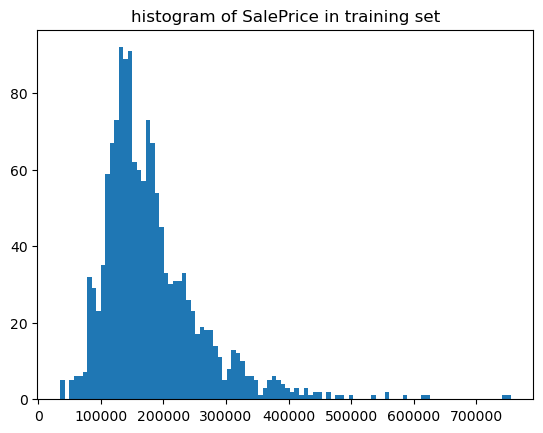

In [162]:
plt.hist(data_train.SalePrice.values, bins=100);
plt.title('histogram of SalePrice in training set')

Text(0.5, 1.0, 'histogram of SalePrice in testing set')

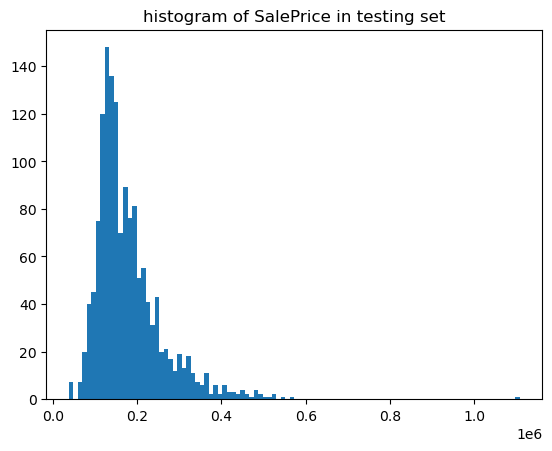

In [164]:
plt.hist(data_test.SalePrice.values, bins=100);
plt.title('histogram of SalePrice in testing set')

### Predict SalePrice using a linear regression model

In [167]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
linear_model = LinearRegression()
linear_model.fit(X_train, Y_train)
Y_train_pred = linear_model.predict(X_train)
Y_test_pred = linear_model.predict(X_test)

show the training result

(0.0, 1000000.0, 0.0, 1000000.0)

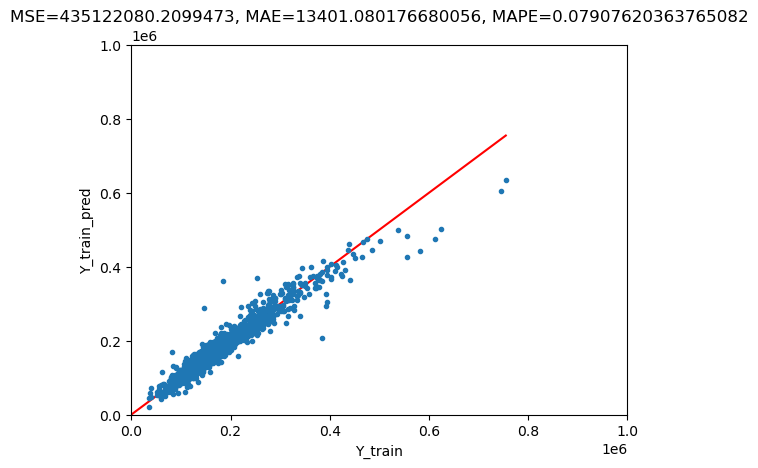

In [170]:
MSE = np.mean((Y_train - Y_train_pred)**2)
MAE = np.mean(np.abs(Y_train - Y_train_pred))
MAPE =  np.mean(np.abs(Y_train - Y_train_pred)/Y_train)
#
ymax=np.max([Y_train.max(), Y_train_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_train, Y_train_pred, '.')
plt.xlabel('Y_train')
plt.ylabel('Y_train_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', MAPE='+str(MAPE))
plt.axis([0, 1e6, 0, 1e6])

show the testing result

(0.0, 1000000.0, 0.0, 1000000.0)

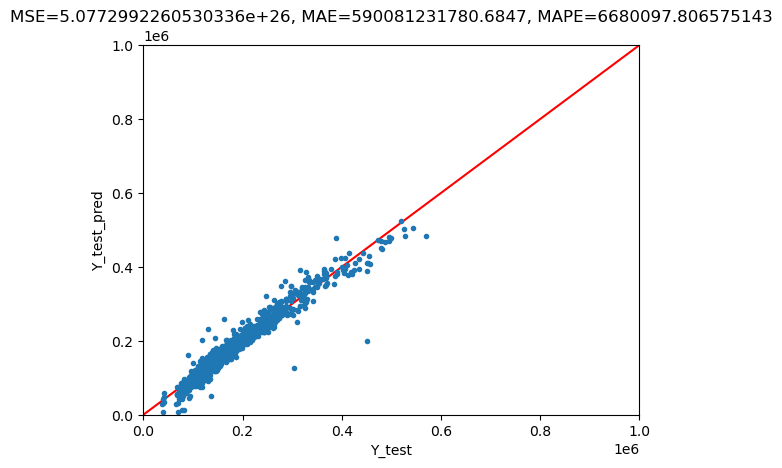

In [173]:
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
MAPE =  np.mean(np.abs(Y_test - Y_test_pred)/Y_test)
#
ymax=np.max([Y_test.max(), Y_test_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_test, Y_test_pred, '.')
plt.xlabel('Y_test')
plt.ylabel('Y_test_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', MAPE='+str(MAPE))
plt.axis([0, 1e6, 0, 1e6])

In [175]:
np.sum(np.abs(Y_test - Y_test_pred)/Y_test>0.1)

322

Perform 10-fold cross valiation to get the average MAPE 

In [178]:
#attention: if you choose to use GridSearchCV
#           it assumes a better model has a higher score
#           thus, my_scorer should return -MAPE as the score of the model
def my_scorer(model, X, y):
    y_pred = model.predict(X)
    #MSE = np.mean((y_pred - y)**2)
    #MAE = np.mean(np.abs(y_pred - y))
    MAPE =  np.mean(np.abs(y_pred - y)/y)
    return MAPE
#
from sklearn.model_selection import cross_val_score
MAPE_array = cross_val_score(linear_model, X_train, Y_train, cv=10, scoring=my_scorer)
MAPE_array

array([1.89897359e+01, 1.03792747e-01, 1.08615645e-01, 1.91715007e+00,
       1.20893875e-01, 1.05430637e-01, 1.07612068e-01, 1.21131582e+03,
       3.39578817e+02, 2.44072902e+03])

#### KNeighborsRegressor

In [183]:
from sklearn.neighbors import KNeighborsRegressor
#use a for loop to do 10-fold cross-valiation to find the best n_neighbors

def my_scorer(model, X, y):
    y_pred = model.predict(X)
    MAPE = np.mean(np.abs(y_pred - y) / y)
    return MAPE

MAPE_average_list = []
hyperparameter_list = list(range(1, 21))

for hyperparameter in hyperparameter_list:
    my_model = KNeighborsRegressor(n_neighbors=hyperparameter)
    MAPE_array = cross_val_score(my_model, X_train, Y_train, cv=10, scoring=my_scorer, n_jobs=4)
    MAPE_average_list.append(MAPE_array.mean())

MAPE_average_list = np.array(MAPE_average_list)

In [184]:
#plot and find the best n_neighbors

best_k = hyperparameter_list[np.argmin(MAPE_average_list)]
best_k


7

Text(0, 0.5, 'MAPE')

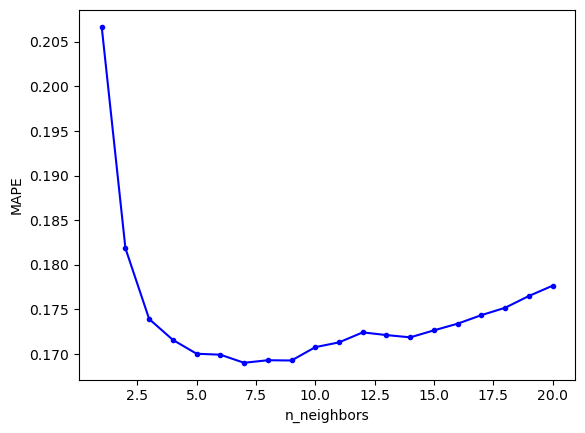

In [185]:
plt.plot(hyperparameter_list, MAPE_average_list, '.-b')
plt.xlabel('n_neighbors')
plt.ylabel('MAPE')


build a KNeighborsRegressor using the best hyperparameter <br>
fit it to the training data and test it on the testing data

In [187]:
best_model = KNeighborsRegressor(n_neighbors=best_k)
best_model.fit(X_train, Y_train)
Y_train_pred = best_model.predict(X_train)
Y_test_pred = best_model.predict(X_test)


show the training result

(0.0, 1000000.0, 0.0, 1000000.0)

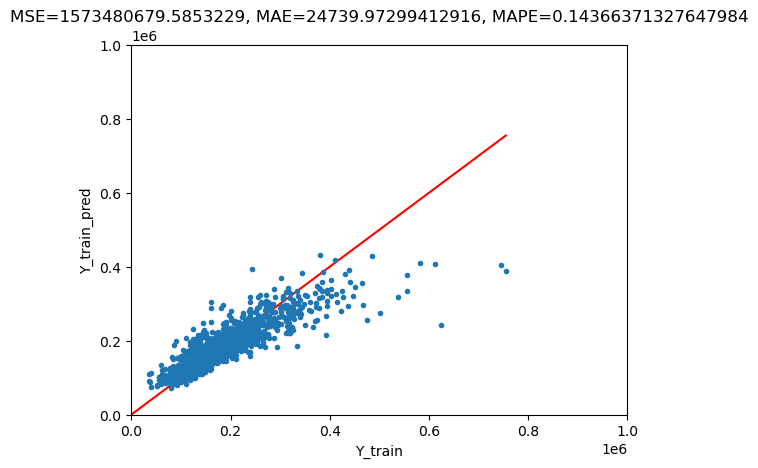

In [189]:
MSE = np.mean((Y_train - Y_train_pred)**2)
MAE = np.mean(np.abs(Y_train - Y_train_pred))
MAPE =  np.mean(np.abs(Y_train - Y_train_pred)/Y_train)
#
ymax=np.max([Y_train.max(), Y_train_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_train, Y_train_pred, '.')
plt.xlabel('Y_train')
plt.ylabel('Y_train_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', MAPE='+str(MAPE))
plt.axis([0, 1e6, 0, 1e6])

show the testing result

(0.0, 1000000.0, 0.0, 1000000.0)

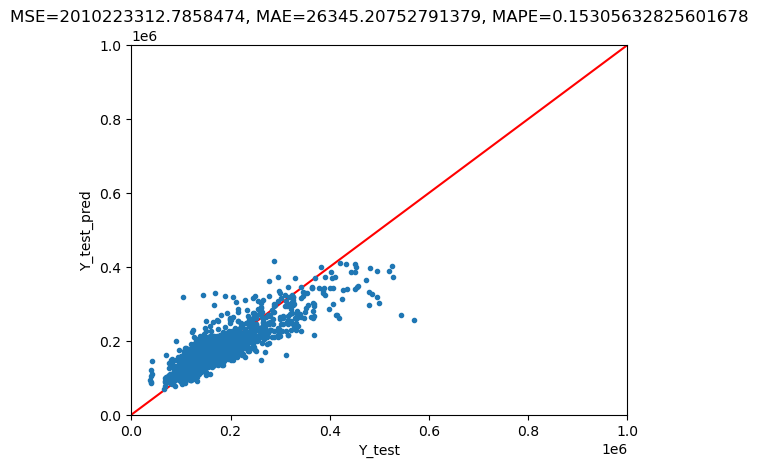

In [191]:
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
MAPE =  np.mean(np.abs(Y_test - Y_test_pred)/Y_test)
#
ymax=np.max([Y_test.max(), Y_test_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_test, Y_test_pred, '.')
plt.xlabel('Y_test')
plt.ylabel('Y_test_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', MAPE='+str(MAPE))
plt.axis([0, 1e6, 0, 1e6])

#### RandomForestRegressor

In [193]:
from sklearn.ensemble import RandomForestRegressor
#use a for loop to do 10-fold cross-valiation to find the best max_depth

def my_scorer(model, X, y):
    y_pred = model.predict(X)
    MAPE = np.mean(np.abs(y_pred - y) / y)
    return MAPE
MAPE_average_list = []
hyperparameter_list = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for hyperparameter in hyperparameter_list:
    my_model = RandomForestRegressor(max_depth=hyperparameter, random_state=0)
    MAPE_array = cross_val_score(my_model, X_train, Y_train, cv=10, scoring=my_scorer, n_jobs=4)
    MAPE_average_list.append(MAPE_array.mean())

MAPE_average_list = np.array(MAPE_average_list)


In [194]:
#plot and find the best max_depth
best_depth = hyperparameter_list[np.argmin(MAPE_average_list)]
best_depth

30

Text(0, 0.5, 'MAPE')

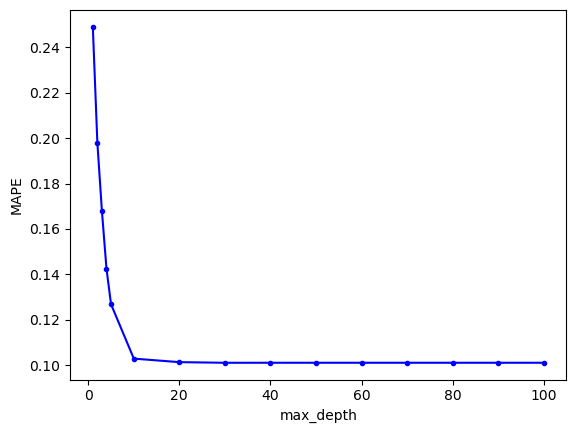

In [195]:
plt.plot(hyperparameter_list, MAPE_average_list, '.-b')
plt.xlabel('max_depth')
plt.ylabel('MAPE')

build a RandomForestRegressor using the best hyperparameter <br> 
fit it to the training data and test it on the testing data

In [203]:
best_model = RandomForestRegressor(max_depth=best_depth)
best_model.fit(X_train, Y_train)
Y_train_pred = best_model.predict(X_train)
Y_test_pred = best_model.predict(X_test)

show the training result

(0.0, 1000000.0, 0.0, 1000000.0)

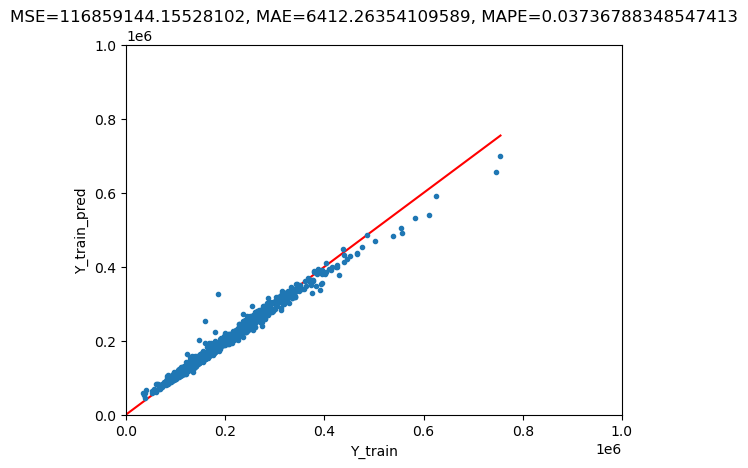

In [205]:
MSE = np.mean((Y_train - Y_train_pred)**2)
MAE = np.mean(np.abs(Y_train - Y_train_pred))
MAPE =  np.mean(np.abs(Y_train - Y_train_pred)/Y_train)
#
ymax=np.max([Y_train.max(), Y_train_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_train, Y_train_pred, '.')
plt.xlabel('Y_train')
plt.ylabel('Y_train_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', MAPE='+str(MAPE))
plt.axis([0, 1e6, 0, 1e6])

show the testing result

(0.0, 1000000.0, 0.0, 1000000.0)

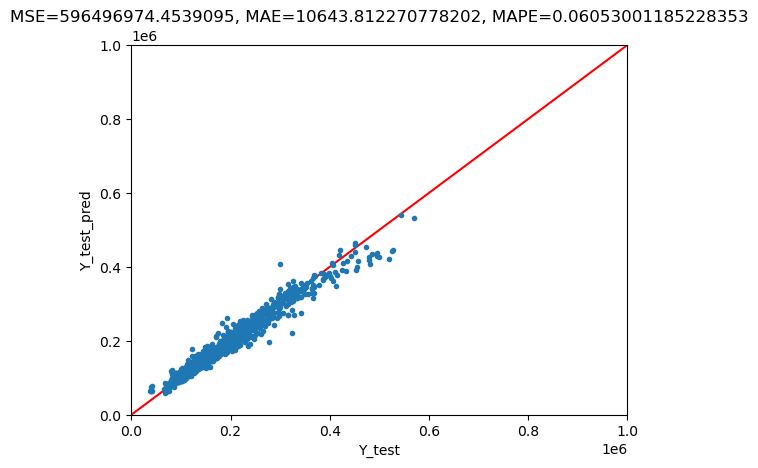

In [207]:
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
MAPE =  np.mean(np.abs(Y_test - Y_test_pred)/Y_test)
#
ymax=np.max([Y_test.max(), Y_test_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_test, Y_test_pred, '.')
plt.xlabel('Y_test')
plt.ylabel('Y_test_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', MAPE='+str(MAPE))
plt.axis([0, 1e6, 0, 1e6])

#### XGBRegressor


In [381]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
#try to use GridSearchCV to do 10-fold cross-valiation to find the best max_depth
#set random_state=0, objective='reg:squarederror'
#read the comments in the cell of "my_scorer", or you can use the "built-in" scorer in sk-learn

param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
}

grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=0, objective='reg:squarederror'),
    param_grid=param_grid,
    scoring='neg_mean_absolute_percentage_error',
    cv=10,
    n_jobs=4,
    return_train_score=True
)

grid_search.fit(X_train, Y_train)


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=Non...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=4,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 60,
                                       70, 80, 90, 100]},
             return_train_score=True,
             scoring='neg_mean_absolute_percentage_error')

In [391]:
#plot and find the best max_depth
cv_results = grid_search.cv_results_
max_depths = cv_results['param_max_depth']
best_depth

4

Text(0, 0.5, 'MAPE')

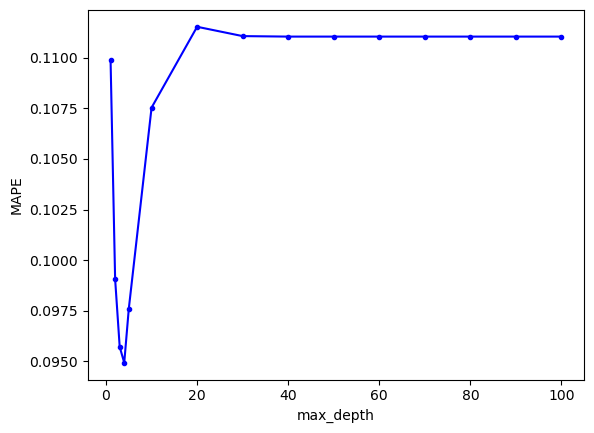

In [393]:
mean_MAPE_scores = -cv_results['mean_test_score']
plt.plot(max_depths, mean_MAPE_scores, '.-b')
plt.xlabel('max_depth')
plt.ylabel('MAPE')

build a XGBRegressor using the best hyperparameter and fit it to the training data

In [396]:
best_model = XGBRegressor(max_depth=best_depth, random_state=0, objective='reg:squarederror')
best_model.fit(X_train, Y_train)
Y_train_pred = best_model.predict(X_train)
Y_test_pred = best_model.predict(X_test)


show the training result

(0.0, 1000000.0, 0.0, 1000000.0)

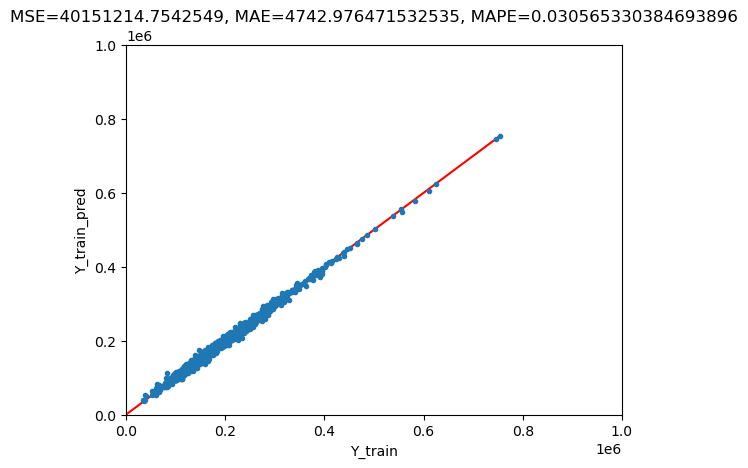

In [399]:
MSE = np.mean((Y_train - Y_train_pred)**2)
MAE = np.mean(np.abs(Y_train - Y_train_pred))
MAPE =  np.mean(np.abs(Y_train - Y_train_pred)/Y_train)
#
ymax=np.max([Y_train.max(), Y_train_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_train, Y_train_pred, '.')
plt.xlabel('Y_train')
plt.ylabel('Y_train_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', MAPE='+str(MAPE))
plt.axis([0, 1e6, 0, 1e6])

show the testing result

(0.0, 1000000.0, 0.0, 1000000.0)

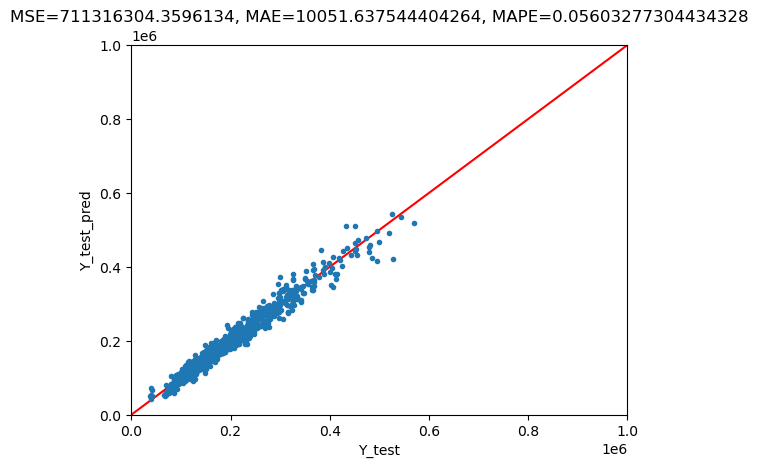

In [402]:
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
MAPE =  np.mean(np.abs(Y_test - Y_test_pred)/Y_test)
#
ymax=np.max([Y_test.max(), Y_test_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_test, Y_test_pred, '.')
plt.xlabel('Y_test')
plt.ylabel('Y_test_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', MAPE='+str(MAPE))
plt.axis([0, 1e6, 0, 1e6])

In [404]:
np.sum(np.abs(Y_test - Y_test_pred)/Y_test>0.1)

219

In this task, linear model is as good as nonlinear models <br>